In [ ]:

# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.67 MiB | 10.82 MiB/s, done.
Resolving deltas: 100% (11704/11704), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.0 MB/s eta 0:00:00
Setup complete. Using torch 2.5.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40, uuid=0b81badb-17e2-af69-a3cf-59dea10ab48f, L2_cache_size=4MB)


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Qoc5VmjMyQiXLL2pQ0jS")
project = rf.workspace("infosysproject-bwdm7").project("ball-player-detection-ygfy8")
version = project.version(1)
dataset = version.download("yolov5")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ball-player-detection-1 in yolov5pytorch:: 100%|██████████| 24/24 [00:00<00:00, 4070.33it/s]


In [ ]:


%cd /content/yolov5

/content/yolov5


In [ ]:
%cat {dataset.location}/data.yaml

names:
- ball
- player 1
- player 2
nc: 3
roboflow:
  license: CC BY 4.0
  project: ball-player-detection-ygfy8
  url: https://universe.roboflow.com/infosysproject-bwdm7/ball-player-detection-ygfy8/dataset/1
  version: 1
  workspace: infosysproject-bwdm7
test: ../test/images
train: ball-player-detection-1/train/images
val: ball-player-detection-1/valid/images


In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:

%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache


/content/yolov5
2024-11-15 17:11:46.492326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 17:11:46.513474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 17:11:46.520100: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 17:11:46.534905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 17:11:47.815687: W tensorf

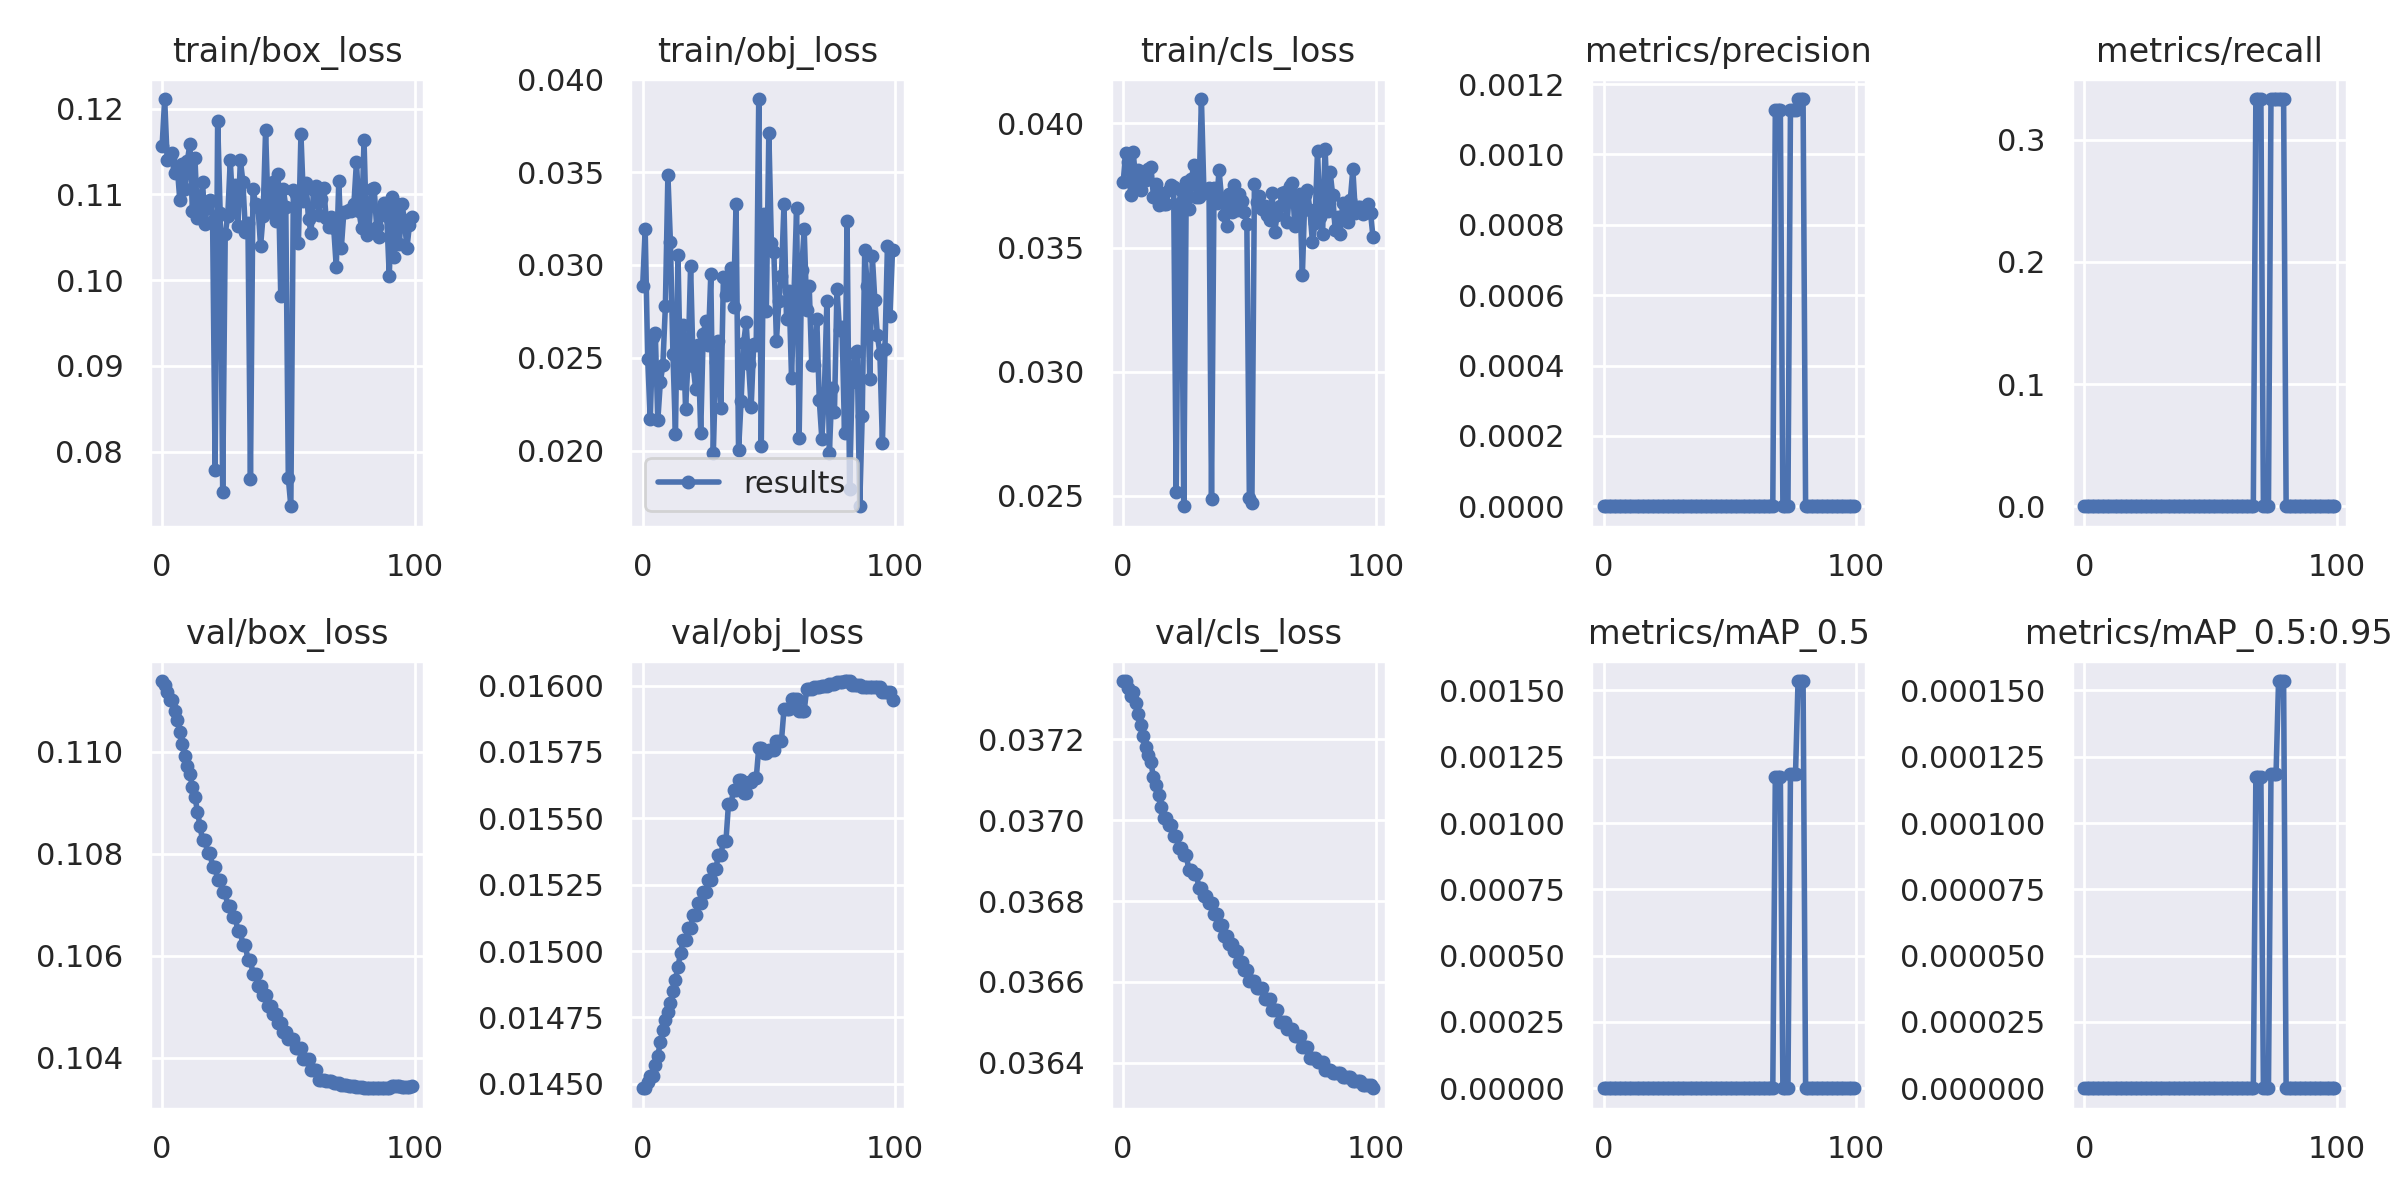

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

In [ ]:


from IPython.display import Image, display

file_path = '/content/frame_0002.jpg'

try:
    display(Image(filename=file_path, width=900))
except FileNotFoundError:
    print(f"File not found: {file_path}. Please check the path and try again.")


File not found: /content/frame_0002.jpg. Please check the path and try again.


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving main.py to main.py


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving input_video.mp4 to input_video.mp4


In [ ]:
!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 22.7 MB/s eta 0:00:00


In [ ]:
!pip install roboflow

from roboflow import Roboflow


In [ ]:
import shutil

In [ ]:
import os

src_dir = r'C:\Users\91868\tennis_analysis\training\tennis-ball-detection-6\train'

if not os.path.exists(src_dir):
    os.makedirs(src_dir)
    print(f"Directory created: {src_dir}")
else:
    print(f"Source directory {src_dir} already exists.")


Directory created: C:\Users\91868\tennis_analysis\training\tennis-ball-detection-6\train


In [ ]:
import os
import shutil

# Define absolute paths for the source and destination directories
src_dir = r'C:\Users\91868\tennis_analysis\training\tennis-ball-detection-6\train'
dst_dir = r'C:\Users\91868\tennis_analysis\training\tennis-ball-detection-6\tennis-ball-detection-6\train'

# Check if the source directory exists
if not os.path.exists(src_dir):
    print(f"Source directory {src_dir} does not exist.")
else:
    # Try to move or copy files
    try:
        # Create destination directory if it does not exist
        os.makedirs(dst_dir, exist_ok=True)
        shutil.move(src_dir, dst_dir)  # or shutil.copy() depending on your logic
        print(f"Moved directory from {src_dir} to {dst_dir}")
    except Exception as e:
        print(f"Error moving file: {e}")


Moved directory from C:\Users\91868\tennis_analysis\training\tennis-ball-detection-6\train to C:\Users\91868\tennis_analysis\training\tennis-ball-detection-6\tennis-ball-detection-6\train


In [ ]:
!yolo task=detect mode=train model=yolov5l6u.pt data={dataset.location}/data.yaml epochs=100 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 165M/165M [00:01<00:00, 88.1MB/s]
Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov5l6u.pt, data={dataset.location}/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, sav

In [ ]:
!wget --header="Host: drive.usercontent.google.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7" --header="Accept-Language: en-US,en;q=0.9,ar;q=0.8" --header="Cookie: HSID=Ag2OIHvsd2Wub4C7z; SSID=AWnBcQKwDHiTrZAU1; APISID=pltrFZgE9lJ0o1gq/AN9feEHYvs8oHd519; SAPISID=zgF45F21ZPWzYWZw/AgUMJ8b7QQXuWGn19; __Secure-1PAPISID=zgF45F21ZPWzYWZw/AgUMJ8b7QQXuWGn19; __Secure-3PAPISID=zgF45F21ZPWzYWZw/AgUMJ8b7QQXuWGn19; SID=g.a000fwgYx1PcnW-rFyFhg3x6mQHzCrwXz-KFhoOLogUl7YTWI-uttBbVDRolhF-hY16nwHXw0gACgYKAWISAQASFQHGX2MivNTw_E_toJuIRy6LMpKNOBoVAUF8yKpFSmvq7AMjvEWeNc50Zff40076; __Secure-1PSID=g.a000fwgYx1PcnW-rFyFhg3x6mQHzCrwXz-KFhoOLogUl7YTWI-utbSY2jBY1VXuw8gYl5hIO2QACgYKAXsSAQASFQHGX2MihVCJ1PwLozGqZgdSatM9QhoVAUF8yKpgrsTvI8i_UE-YHpoN7Gx-0076; __Secure-3PSID=g.a000fwgYx1PcnW-rFyFhg3x6mQHzCrwXz-KFhoOLogUl7YTWI-utwVfPl2imdPimZJ9tdDZGQAACgYKAUESAQASFQHGX2MiEJ49mV4jME2kttDAV5hwWBoVAUF8yKp80mIgju1lu-q4nI7VsFDM0076; NID=511=efI9IZpxtyJ7Dw1MAUXU8FlzS5jXGewY4Er8HliWc3A0RSWdgvNDyKY66ETjgRyTGWPbWODSmiSeYSBab5SPHVwqbJxd6ZeGW2f6BkHi61UKksXPH0CVJRM1hKpMjHPU5qw7tboM2Mi87NrosV8COB-GCLulLLbjOoSAEQewTe8NVZ5Owq8IkwvxFGfJkmUKEMkFWrw9yb5nTDl3wbZEsGFI92iEdNTSxSRovNCIPN2US-SCFdQ0m2BtvwdiWZbgnn7dSQ8yPA145Kk2BA-ATpJNJ6SJHEHLQY-9CPail9D5qgJgxR925EUg5RGCpEu9wS5xbA62KTa19wAvbAq7Dk3TWc-iX4p1s7ESFyDC7yMpFxiFPJjqkWwFi_ZfiK2TW2t0TQ60DFBxqOytQaLyHrkEvD-CQPVj6OCOP22cZY0Cu61HaAQgFO9pXH-kJUlywzVdbirJumN5gswyaQ49b3KdLcG0Jb7brOMTM24T2nGtQ10hJzsnTwX7dBk3ujqQrI_DGuURvPassPUrIZ0; AEC=Ae3NU9MOEGeKAZjP6INpOYbyMraWAWztmx5pJB_1ILu1furiTy1K37k15u0; __Secure-1PSIDTS=sidts-CjEBYfD7Z9twEKTWJ9gU7KG-rLbxJGNRQIoG3wH6JVu6yiCC2fsRrm7tN8L6d5WlILrnEAA; __Secure-3PSIDTS=sidts-CjEBYfD7Z9twEKTWJ9gU7KG-rLbxJGNRQIoG3wH6JVu6yiCC2fsRrm7tN8L6d5WlILrnEAA; 1P_JAR=2024-02-18-08; SIDCC=ABTWhQExCxkfmwCkG1RaEgz8U1ZkPeh3HmLMUdMt8S5cNSsLY5U5rAL6wlvq7dtjRw7zrtAbqsFI; __Secure-1PSIDCC=ABTWhQH0jLeRIS6Tu3LS8DXB5Q3gGDq9LTmlk60FKu795Bf0UbzsOcYWVAE96clq5aAL8i724Q0; __Secure-3PSIDCC=ABTWhQHIFcyv3nZYwp78WXEQal71jCE_ZsGT5lXs8VLr7XDIfFqHcLTIPz4HxzJb9ZnYQ5l2s9eU" --header="Connection: keep-alive" "https://drive.usercontent.google.com/download?id=1lhAaeQCmk2y440PmagA0KmIVBIysVMwu&export=download&authuser=0&confirm=t&uuid=3077628e-fc9b-4ef2-8cde-b291040afb30&at=APZUnTU9lSikCSe3NqbxV5MVad5T%3A1708243355040" -c -O 'tennis_court_det_dataset.zip'

--2024-11-15 18:31:18--  https://drive.usercontent.google.com/download?id=1lhAaeQCmk2y440PmagA0KmIVBIysVMwu&export=download&authuser=0&confirm=t&uuid=3077628e-fc9b-4ef2-8cde-b291040afb30&at=APZUnTU9lSikCSe3NqbxV5MVad5T%3A1708243355040
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7255696316 (6.8G) [application/octet-stream]
Saving to: ‘tennis_court_det_dataset.zip’

tennis_court_det_da 100%[===================>]   6.76G  70.2MB/s    in 2m 1s   

2024-11-15 18:33:21 (57.2 MB/s) - ‘tennis_court_det_dataset.zip’ saved [7255696316/7255696316]



In [ ]:
!unzip tennis_court_det_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/images/JNKp7sCdQlY_2200.png  
  inflating: data/images/JNKp7sCdQlY_2250.png  
  inflating: data/images/JNKp7sCdQlY_250.png  
  inflating: data/images/JNKp7sCdQlY_300.png  
  inflating: data/images/JNKp7sCdQlY_350.png  
  inflating: data/images/JNKp7sCdQlY_400.png  
  inflating: data/images/JNKp7sCdQlY_450.png  
  inflating: data/images/JNKp7sCdQlY_50.png  
  inflating: data/images/JNKp7sCdQlY_500.png  
  inflating: data/images/JNKp7sCdQlY_550.png  
  inflating: data/images/JNKp7sCdQlY_600.png  
  inflating: data/images/JNKp7sCdQlY_650.png  
  inflating: data/images/JNKp7sCdQlY_700.png  
  inflating: data/images/JNKp7sCdQlY_750.png  
  inflating: data/images/juXbdW7z0WA_100.png  
  inflating: data/images/juXbdW7z0WA_1050.png  
  inflating: data/images/juXbdW7z0WA_1100.png  
  inflating: data/images/juXbdW7z0WA_200.png  
  inflating: data/images/juXbdW7z0WA_350.png  
  inflating: data/images/juXbdW7z0WA_400.png  
  infl

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import json
import cv2
import numpy as np

In [ ]:
devic = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class KeypointsDataset(Dataset):
    def __init__(self, img_dir, data_file):
        self.img_dir = img_dir
        with open(data_file, "r") as f:
            self.data = json.load(f)

        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = cv2.imread(f"{self.img_dir}/{item['id']}.png")
        h,w = img.shape[:2]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(img)
        kps = np.array(items['kps']).flatten()
        kps = kps.astype(np.float32)

        kps[::2] *= 224.0 / w # Adjust x coordinates
        kps[1::2] *= 224.0 / h # Adjust y coordinates

        return img, kps

In [ ]:

train_dataset = KeypointsDataset("data/images","data/data_train.json")
val_dataset = KeypointsDataset("data/images","data/data_val.json")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)


In [ ]:
model = models.resnet50(pretrained=True)
model.fc =  torch.nn.Linear(model.fc.in_features, 14*2) # Replaces the last layer

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


In [ ]:
from ultralytics import YOLO
import cv2
import pickle
import pandas as pd

class BallTracker:

    def __init__(self,model_path) :
        self.model = YOLO(model_path)

    def interpolate_ball_position(self, ball_positions):
        ball_positions  =[x.get(1,[]) for x in ball_positions]

        #convert list into pandas dataframe
        df_ball_position = pd.DataFrame(ball_positions, columns=['x1','y1','x2','y2'])

        #interpolate missing values
        df_ball_position = df_ball_position.interpolate()
        df_ball_position = df_ball_position.bfill()

        ball_positions = [{1:x} for x in df_ball_position.to_numpy().tolist()]

        return ball_positions

    def get_ball_shot_frame(self, ball_positions):
        ball_positions  =[x.get(1,[]) for x in ball_positions]
        #convert list into pandas dataframe
        df_ball_position = pd.DataFrame(ball_positions, columns=['x1','y1','x2','y2'])

        df_ball_position['mid_y'] = (df_ball_position['y1']+df_ball_position['y2'])/2
        df_ball_position['mid_y_rolling_mean'] = df_ball_position['mid_y'].rolling(window=10, min_periods=1, center=False).mean()
        df_ball_position['delta_y'] = df_ball_position['mid_y_rolling_mean'].diff()
        df_ball_position['ball_hit'] = 0

        minimum_change_frames_for_hit = 25
        for i in range(0, len(df_ball_position)-int(minimum_change_frames_for_hit*1.2)):
            negative_position_change = df_ball_position['delta_y'].iloc[i] >0 and df_ball_position['delta_y'].iloc[i+1] < 0
            positive_position_change = df_ball_position['delta_y'].iloc[i] <0 and df_ball_position['delta_y'].iloc[i+1] > 0

            if positive_position_change or negative_position_change:
                change_count = 0
                for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
                    negative_position_change_following_frame = df_ball_position['delta_y'].iloc[i] >0 and df_ball_position['delta_y'].iloc[change_frame] < 0
                    positive_position_change_following_frame = df_ball_position['delta_y'].iloc[i] <0 and df_ball_position['delta_y'].iloc[change_frame] > 0

                    if negative_position_change and negative_position_change_following_frame:
                        change_count += 1
                    elif positive_position_change and positive_position_change_following_frame:
                        change_count += 1

                if change_count > minimum_change_frames_for_hit-1:
                    df_ball_position['ball_hit'].iloc[i] = 1

        frame_nums_with_ball_hits = df_ball_position[df_ball_position['ball_hit']==1].index.to_list()

        return frame_nums_with_ball_hits


    def detect_frames(self,frames, read_from_stub=False, stub_path=None):
        ball_detections = []

        if read_from_stub and stub_path is not None:
            with open(stub_path, 'rb') as f:
                ball_detections = pickle.load(f)
            return ball_detections

        for frame in frames:
            player_dict = self.detect_frame(frame)
            ball_detections.append(player_dict)

        if stub_path is not None:
            with open(stub_path, 'wb') as f:
                pickle.dump(ball_detections, f)

        return ball_detections

    def detect_frame(self,frame):
        results = self.model.predict(frame,conf=0.15)[0]

        ball_dict = {}
        for box in results.boxes:
            result = box.xyxy.tolist()[0]
            ball_dict[1] = result

        return ball_dict

    def draw_bboxes(self, video_frames, ball_detections):
        output_video_frames = []
        for frame, ball_dict in zip(video_frames,ball_detections):
            # Draw Bounding Boxes
            for track_id, bbox in ball_dict.items():
                x1,y1,x2,y2 = bbox
                cv2.putText(frame, f"Ball ID: {track_id}", (int(bbox[0]), int(bbox[1]-10 )), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 255), 2)

            output_video_frames.append(frame)

        return output_video_frames

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import cv2

class CourtLineDetector:
    def __init__(self, model_path):
        self.model = models.resnet50(pretrained=True)
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 14*2)
        self.model.load_state_dict(torch.load(model_path, map_location="cpu"))

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, image):
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_tensor = self.transform(img_rgb).unsqueeze(0)

        with torch.no_grad():
            output = self.model(image_tensor)
        keypoints = output.squeeze().cpu().numpy()
        original_h, original_w = image.shape[:2]
        keypoints[::2] *= original_w/224.0      #for width
        keypoints[1::2] *= original_h/224.0     #for height

        return keypoints

    def draw_keypoints(self, image, keypoints):
        for i in range(0, len(keypoints), 2):
            x = int(keypoints[i])
            y = int(keypoints[i+1])

            cv2.putText(image, str(i//2), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)
            cv2.circle(image, (x,y), 5, (0,0,255), -1)

        return image

    def draw_keypoints_on_video(self, video_frames, keypoints):
        output_video_frames = []
        for  frame in video_frames:
            frame = self. draw_keypoints(frame, keypoints)
            output_video_frames.append(frame)

        return output_video_frames

In [ ]:
!pip install opencv-python-headless
!pip install pandas
!pip install torch torchvision
!pip install roboflow


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will allow you to upload files manually


Saving __init__.py to __init__.py
Saving court_line_detector.py to court_line_detector.py


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will allow you to upload files manually


Saving __init__.py to __init__ (1).py


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will allow you to upload files manually


Saving __init__.py to __init__ (2).py
Saving mini_court.py to mini_court.py


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will allow you to upload files manually


Saving ball_detection.pkl to ball_detection.pkl
Saving player_detection.pkl to player_detection.pkl


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will allow you to upload files manually


Saving __init__.py to __init__ (3).py
Saving ball_tracker.py to ball_tracker.py
Saving player_tracker.py to player_tracker.py


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will allow you to upload files manually


Saving tennis_ball_detector_training.ipynb to tennis_ball_detector_training.ipynb
Saving tennis_court_keypoints_training.ipynb to tennis_court_keypoints_training.ipynb


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will allow you to upload files manually


Saving data.yaml to data.yaml
Saving README.dataset.txt to README.dataset.txt
Saving README.roboflow.txt to README.roboflow.txt


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will allow you to upload files manually


Saving __init__.py to __init__ (4).py
Saving bbox_utils.py to bbox_utils.py
Saving conversions.py to conversions.py
Saving player_stats_drawer_utils.py to player_stats_drawer_utils.py
Saving video_utils.py to video_utils.py


In [ ]:
input_video_path = '/content/input_video.mp4'  # Path after uploading
player_tracker_model_path = '/content/yolov8x'  # Upload and use this path
ball_tracker_model_path = '/content/yolo5_last.pt'  # Same for the ball tracker model
court_line_model_path = '/content/keypoints_model.pth'  # Similarly upload and reference


In [ ]:
output_video_path = '/content/output_video_3.avi'  # Save path in Colab environment


In [ ]:
from google.colab import files
uploaded = files.upload()



Saving output_ball_detections.avi to output_ball_detections.avi
Saving output_court_detections.avi to output_court_detections.avi
Saving output_player_detections.avi to output_player_detections.avi


In [ ]:
from google.colab import files
import zipfile
import os

# Upload the zip file
uploaded = files.upload()  # This will allow you to select the zip file to upload

# Once uploaded, unzip the file
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        zip_file_path = filename
        output_dir = filename.replace('.zip', '')  # Create a directory based on the zip file name

        # Make the directory for extracting files
        os.makedirs(output_dir, exist_ok=True)

        # Unzip the file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print(f"Folder extracted to: {output_dir}")
